##Project for Music Generate by LSTM

  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# music21이 필요할 경우 설치 
pip install music21;


In [3]:
import time
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import keras.optimizers 


Using TensorFlow backend.


In [0]:
# music21을 활용해 샘플 midi파일의 요소 살펴보기
file = 'drive/My Drive/MGP/LSTM1/midi_data/ect2/monody solo.mid'
midi = converter.parse(file)
notes_to_parse = midi.flat.notes
for element in notes_to_parse[:10]:
  print(element, element.offset)

MIDI데이터 입력

In [8]:
notes = []
for i, file in enumerate(glob.glob('drive/My Drive/MGP/LSTM1/midi_data/ect2/*.mid')):
  midi = converter.parse(file)
  print('\r', 'Parsing file ', i, " ", file)
  notes_to_parse = None
  try: #file has instrument parts
    s2 = instrument.partitionByInstrument(midi)
    notes_to_parse = s2.parts[0].recurse()
  except: #file has notes in a flat structure
    notes_to_parse = midi.flat.notes

  for element in notes_to_parse:
    if isinstance(element, note.Note):
      notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      notes.append('.'.join(str(n) for n in element.normalOrder))

# with open('notes', 'wb') as filepath:
#   pickle.dump(notes, filepath)

 Parsing file  0   drive/My Drive/MGP/LSTM1/midi_data/ect2/bound solo.mid
 Parsing file  1   drive/My Drive/MGP/LSTM1/midi_data/ect2/stellar.mid
 Parsing file  2   drive/My Drive/MGP/LSTM1/midi_data/ect2/touch.mid
 Parsing file  3   drive/My Drive/MGP/LSTM1/midi_data/ect2/bound1.mid
 Parsing file  4   drive/My Drive/MGP/LSTM1/midi_data/ect2/original.mid
 Parsing file  5   drive/My Drive/MGP/LSTM1/midi_data/ect2/never be alone solo.mid
 Parsing file  6   drive/My Drive/MGP/LSTM1/midi_data/ect2/monody solo.mid
 Parsing file  7   drive/My Drive/MGP/LSTM1/midi_data/ect2/wooboost.mid
 Parsing file  8   drive/My Drive/MGP/LSTM1/midi_data/ect2/star_child.mid


In [10]:
notes[15:25]

['8', '6', '4', 'C#3', 'E3', '4', '3', '11', '4', '3']

In [11]:
len(notes)

2702

In [13]:
# 이 셀의 코드 이해에 대한 도움이 필요하다면 sung kim 교수의 유튜브 강의를 참고
# https://www.youtube.com/watch?v=2R6nfCNNz1U&list=PLlMkM4tgfjnLSOjrEJN31gZATbcj_MpUm&index=44

# 서로 다른 notes 개수
n_vocab=len(set(notes))
print("unique notes: ", n_vocab)

sequence_length = 30     #window

pitchnames = sorted(set(item for item in notes))
#note를 number로 매핑
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

unique notes:  148


In [0]:
network_input = []
network_output = []

#data encoding
for i in range(0, len(notes) - sequence_length, 1):
  sequence_in = notes[i: i+sequence_length]
  sequence_out = notes[i + sequence_length]
  network_input.append([note_to_int[char] for char in sequence_in])
  network_output.append(note_to_int[sequence_out])

In [0]:
np.shape(network_input)

(2672, 30)

In [0]:
n_patterns = len(network_input)
#vectorize input
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))


In [0]:
np.shape(network_input)

(2672, 30, 1)

In [0]:
type(network_input)

numpy.ndarray

In [0]:

#normalize input
network_input = network_input / float(n_vocab)

#network_output을 One Hot Encoding으로 변환
network_output = np_utils.to_categorical(network_output)


In [0]:
network_input[0][0:5]

array([[0.58108108],
       [0.06756757],
       [0.32432432],
       [0.58108108],
       [0.06756757]])

In [0]:
network_input.shape[1]

30

In [0]:
network_input.shape[2]

1

모델 생성


In [0]:
def create_network(network_input, n_vocab):
  """ Create the structure of the neural entwork """
  
  
  model = Sequential()
  model.add(LSTM(
      512, input_shape=(network_input.shape[1], network_input.shape[2]),
      return_sequences = True
  ))
  model.add(Dropout(0.3))
  model.add(LSTM(512, return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(512))
  model.add(Dense(256))
  model.add(Dropout(0.3))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
  return model

In [0]:
model = create_network(network_input, n_vocab)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 512)           1052672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    

In [0]:
#텐서보드 사용과 체크포인트 설정

batch_size=64

filepath = 'drive/My Drive/MGP/weights/w_ect2/{epoch:02d}-{loss:.4f}.h5'
callback_list=[
              #  TensorBoard(log_dir=LOG_DIR, histogram_freq=1),
               ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
]

In [0]:
# model.fit을 이어서 하려면은 아래 코드 실행

# weights = 'drive/My Drive/MGP/weights/w_chopin/741-0.23.h5' 
# model.load_weights(weights)

In [0]:
print("start fit: ", time.strftime('%c', time.localtime(time.time())))
history =  model.fit(network_input, 
            network_output, 
            epochs = 500, 
            batch_size=batch_size, 
            validation_data=None,
            callbacks = callback_list)

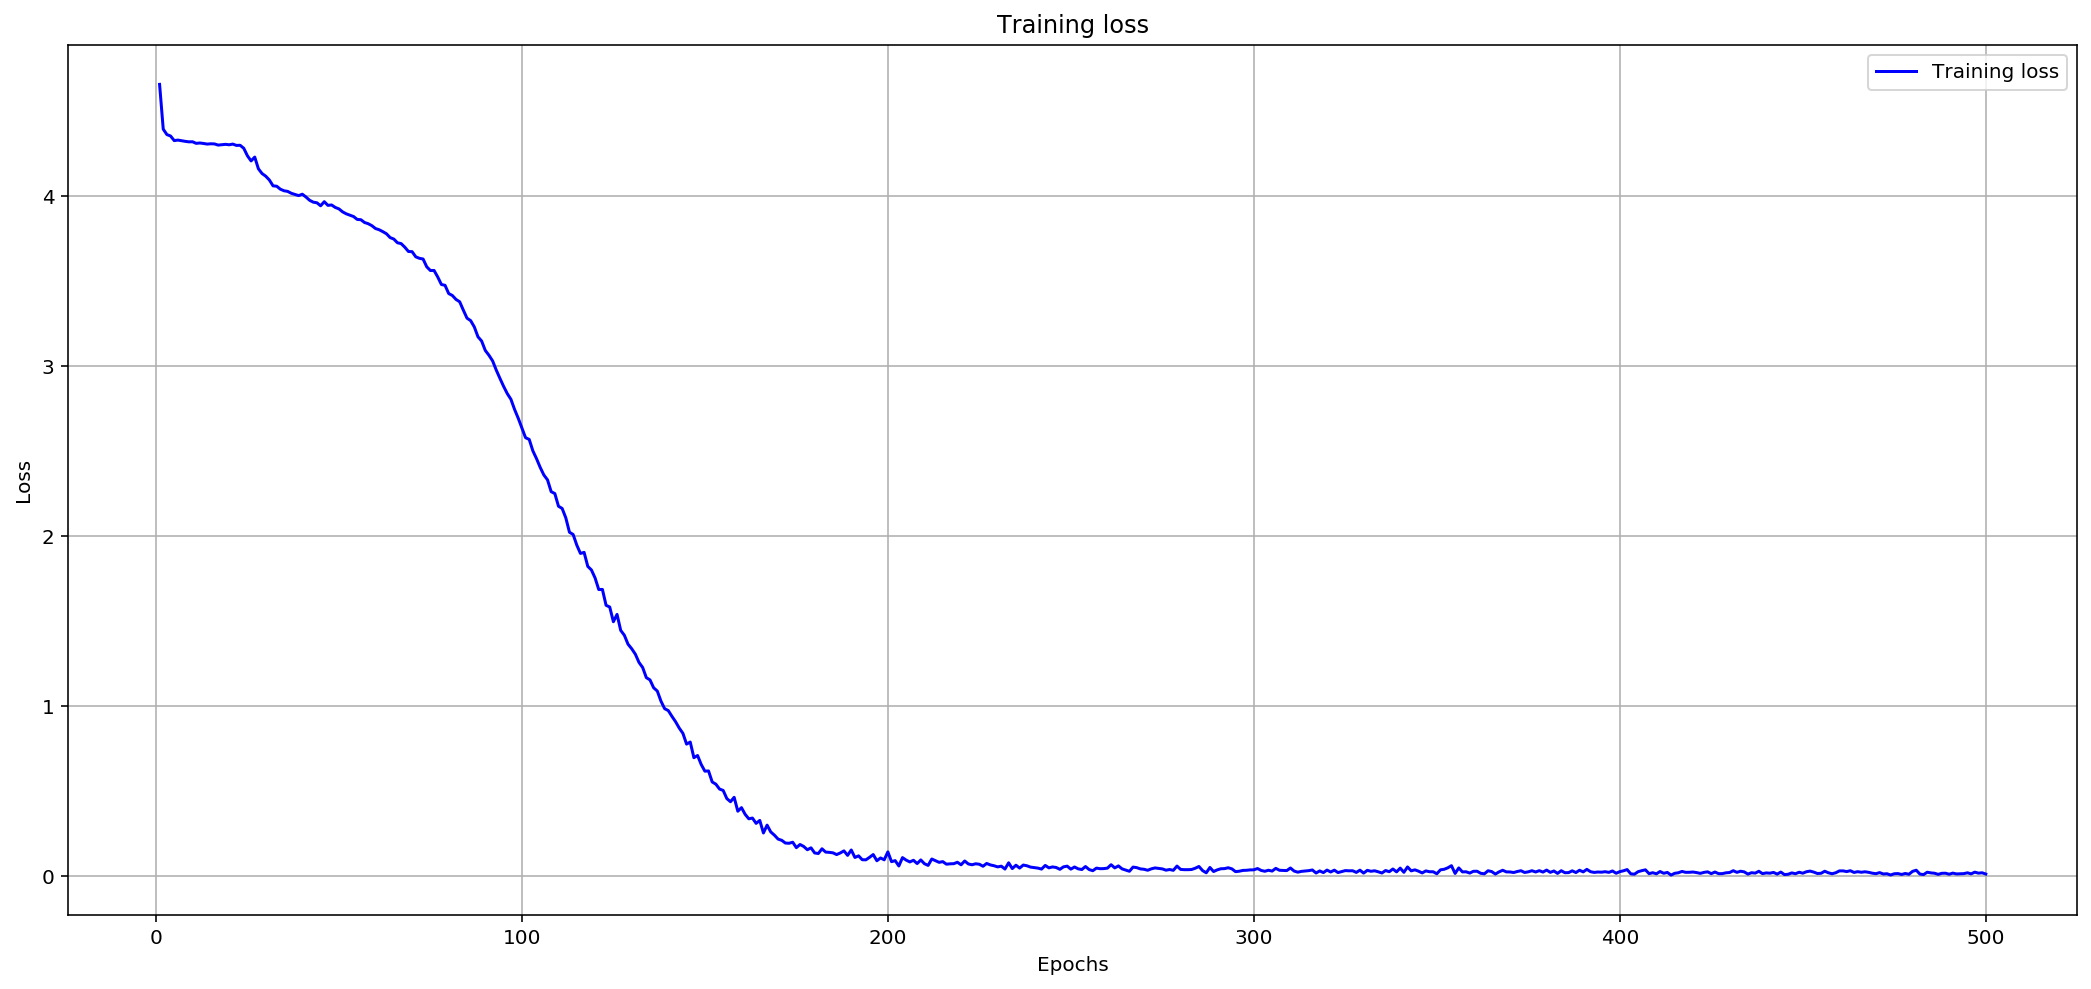

In [0]:
history_dict = history.history
loss = history_dict['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label = 'Training loss') 
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True 
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('drive/My Drive/MGP/fig1.png', dpi=300)
plt.show()

###음악 생성

In [0]:
network_input = []
output = []
for i in range(0, len(notes) - sequence_length, 1):
  sequence_in = notes[i:i + sequence_length]
  sequence_out = notes[i + sequence_length]
  network_input.append([note_to_int[char] for char in sequence_in])
  output.append(note_to_int[sequence_out])
n_patterns = len(network_input)

In [0]:
np.shape(network_input)

(2672, 30)

In [0]:
#이미 학습된 weight 파일을 사용하려면 아래 코드 실행
g_weights = 'drive/My Drive/MGP/weights/w_ect2/191-0.1081.h5'  #0000자리에 파일명을 쓸것
model.load_weights(g_weights)

In [0]:
#첫 note를 랜덤 생성
start = np.random.randint(0, len(network_input)-1 )
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []

#generate notes
for i, note_index in enumerate(range(256)):  #생성할 note 길이
  prediction_input = np.reshape(pattern, (1, len(pattern), 1))
  prediction_input = prediction_input / float(n_vocab)

  prediction = model.predict(prediction_input, verbose=0) #모델의 예측값
  index = np.argmax(prediction) # note에 대응하는 index값
  result = int_to_note[index] #index에 해당하는 원래 note

  print('\r', 'Predicted', i, ' ', result)
  prediction_output.append(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]


In [0]:
#모델을 통해 생성된 값을 기반으로 새로운 음악 생성

offset = 0
output_notes = []

for pattern in prediction_output:
  if('.' in pattern) or pattern.isdigit():
    notes_in_chord = pattern.split('.')
    notes = []
    for current_note in notes_in_chord:
      new_note = note.Note(int(current_note))
      new_note.storedInstrument = instrument.Piano()
      notes.append(new_note)
    
    new_chord = chord.Chord(notes)
    new_chord.offset = offset
    output_notes.append(new_chord)

  else:
    new_note = note.Note(pattern)
    new_note.offset = offset
    new_note.storedInstrument = instrument.Piano()
    output_notes.append(new_note)

  offset += 0.3  #한 note다음 offset을 줌.

In [0]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp = 'drive/My Drive/MGP/result/output_191-0.10.mid')

'drive/My Drive/MGP/result/output_191-0.10.mid'